In [1]:
from smard import SmardApi
from datetime import datetime as dt
from datetime import timedelta as td
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.gridspec import GridSpec
plt.rcParams['figure.figsize'] = [15, 9]  # inches
matplotlib.rcParams.update({'font.size': 14})

In [2]:
TOTAL_ELECTRICAL_POWER: float = 10632.75  # MW
COAL_ENERGY_CONTENT: float = 5.56  # MWh/t
SECONDS_PER_QUARTER_HOUR: int = (60 // 4) * 60  # s
COAL_PER_TRAIN: float = 960.0  # t
POWER_STATIONS: dict[str, dict[str, float]] = {
    "jaenschwalde": {
        "electrical_power": 3000.0,  # MW
        "thermal_power": 349.0,  # MW
        "efficiency": 0.355,
        "name": "Jänschwalde"
    },
    "boxberg": {
        "electrical_power": 2582.0,  # MW
        "thermal_power": 125.0,  # MW
        "efficiency": 0.42,
        "name": "Boxberg"
    },
    "schwarze_pumpe": {
        "electrical_power": 1600.0,  # MW
        "thermal_power": 120.0,  # MW
        "efficiency": 0.4,
        "name": "Schwarze Pumpe"
    },
}
SMARD_API_START_DT: dt = dt(2014, 12, 29, 0, 0)

In [3]:
class Calculation:

    power_station: str
    scaling_factor: float
    start_datetime: dt
    end_datetime: dt
    api: SmardApi

    def __init__(self, start_datetime: dt, end_datetime: dt, power_station: str, scaling_factor: float = 1.0):
        self.start_datetime = start_datetime
        self.end_datetime = end_datetime
        self.power_station = power_station
        self.scaling_factor = scaling_factor
        self.api = SmardApi()

    def coal_consumption(self, produced_electrical_power: float) -> float:
        max_electrical_power = POWER_STATIONS[self.power_station]["electrical_power"]  # MW
        max_thermal_power = POWER_STATIONS[self.power_station]["thermal_power"]  # MW
        efficiency = POWER_STATIONS[self.power_station]["efficiency"]
        duration = produced_electrical_power / TOTAL_ELECTRICAL_POWER  # h
        coal_mass = (duration * (max_electrical_power + max_thermal_power) / (COAL_ENERGY_CONTENT * efficiency))  # t
        return coal_mass * self.scaling_factor
    
    def train_amount(self, coal_mass: float) -> float:
        return coal_mass / COAL_PER_TRAIN
    
    def get_coal_data(self):
        data = self.api.get_data(self.start_datetime, self.end_datetime)
        t = np.array([d.timestamp for d in data])
        y = np.array([self.coal_consumption(d.value) for d in data])
        return t, y
    
    def get_cum_coal_data(self):
        data = self.api.get_data(self.start_datetime, self.end_datetime)
        t = np.array([d.timestamp for d in data])
        y = np.array([self.coal_consumption(d.value) for d in data])
        y = np.cumsum(y)
        return t, y
    
    def get_fmod_data(self):
        data = self.api.get_data(self.start_datetime, self.end_datetime)
        t = np.array([d.timestamp for d in data])
        y = np.array([self.coal_consumption(d.value) for d in data])
        y = np.cumsum(y)
        y = np.fmod(y, COAL_PER_TRAIN)
        return t, y

In [4]:
# POWER_STATION: list[str] = ["jaenschwalde", "boxberg", "schwarze_pumpe"]
DAYS: tuple[dt, dt] = (dt(2023, 1, 25), dt(2023, 1, 30))
DAY_A: tuple[dt, dt] = (dt(2023, 1, 26, 12, 0, 0), dt(2023, 1, 27, 11, 59, 59))
DAY_B: tuple[dt, dt] = (dt(2023, 1, 28, 12, 0, 0), dt(2023, 1, 29, 11, 59, 59))

In [5]:
days_calculation = Calculation(*DAYS, list(POWER_STATIONS.keys())[0])
day_a_calculation = Calculation(*DAY_A, list(POWER_STATIONS.keys())[0])
day_b_calculation = Calculation(*DAY_B, list(POWER_STATIONS.keys())[0])

january_t, january_y = days_calculation.get_coal_data()
day_a_t, day_a_y = day_a_calculation.get_coal_data()
day_b_t, day_b_y = day_b_calculation.get_coal_data()

day_a_cum_t, day_a_cum_y = day_a_calculation.get_cum_coal_data()
day_b_cum_t, day_b_cum_y = day_b_calculation.get_cum_coal_data()

day_a_fmod_t, day_a_fmod_y = day_a_calculation.get_fmod_data()
day_b_fmod_t, day_b_fmod_y = day_b_calculation.get_fmod_data()

day_a_is_spawn = np.r_[True, day_a_fmod_y[1:] < day_a_fmod_y[:-1]] & np.r_[day_a_fmod_y[:-1] < day_a_fmod_y[1:], True]
day_b_is_spawn = np.r_[True, day_b_fmod_y[1:] < day_b_fmod_y[:-1]] & np.r_[day_b_fmod_y[:-1] < day_b_fmod_y[1:], True]
day_a_is_spawn[0] = False
day_b_is_spawn[0] = False
day_a_spawn_indices = np.where(day_a_is_spawn)[0]
day_b_spawn_indices = np.where(day_b_is_spawn)[0]
day_a_spawn_ts = np.array([day_a_fmod_t[i] for i in day_a_spawn_indices])
day_b_spawn_ts = np.array([day_b_fmod_t[i] for i in day_b_spawn_indices])

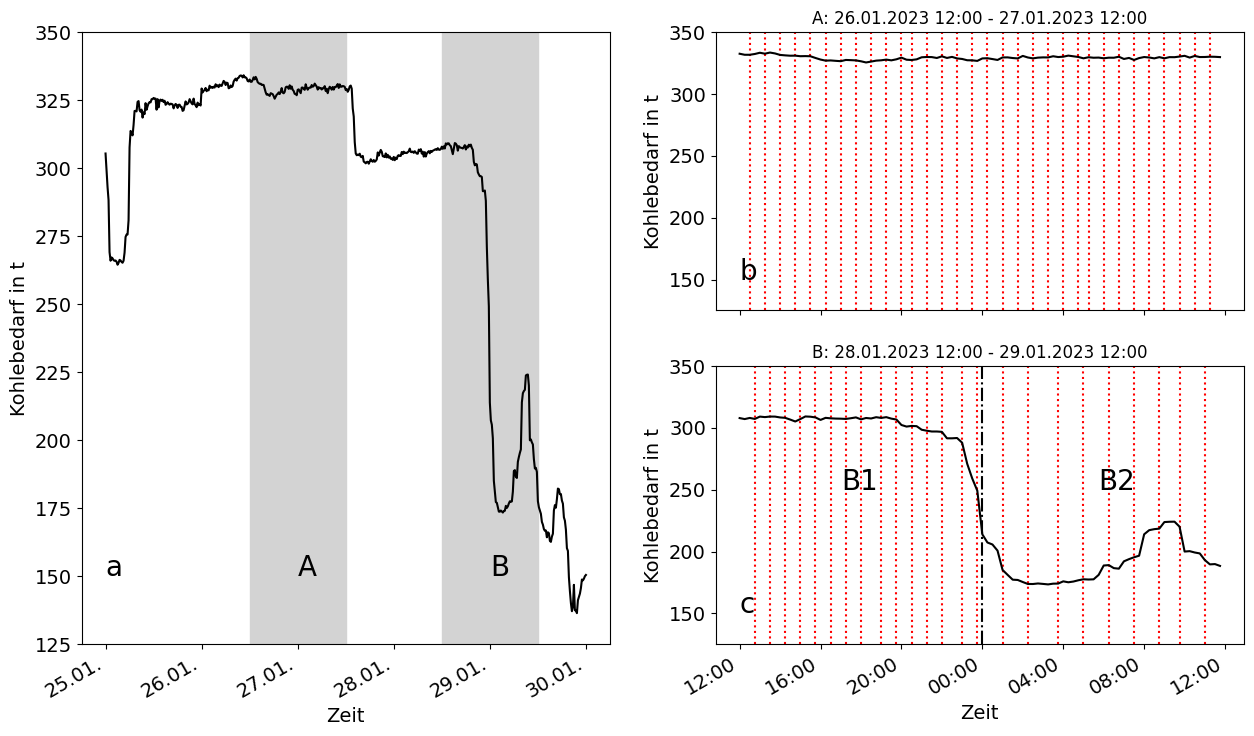

In [24]:
fig = plt.figure()
gs = GridSpec(2, 2, figure=fig)
ax_l = fig.add_subplot(gs[:, 0])
ax_r_t = fig.add_subplot(gs[0, 1])
ax_r_b = fig.add_subplot(gs[1, 1])

ax_l.set_ylim(125, 350)
ax_r_t.set_ylim(125, 350)
ax_r_b.set_ylim(125, 350)

ax_l.axvspan(*DAY_A, alpha=1, color='lightgray')
ax_l.axvspan(*DAY_B, alpha=1, color='lightgray')
ax_l.plot(january_t, january_y, label="January", color='black')

for t in day_a_spawn_ts:
    ax_r_t.axvline(t, color='r', linestyle='dotted')
ax_r_t.plot(day_a_t, day_a_y, label="Day A", color='black')

for t in day_b_spawn_ts:
    ax_r_b.axvline(t, color='r', linestyle='dotted')
ax_r_b.axvline(dt(DAY_B[0].year, DAY_B[0].month, DAY_B[0].day, 23, 59, 59), color='black', linestyle='dashdot')
ax_r_b.text(day_b_t[20], 250, "B1", color='black', fontsize=20)
ax_r_b.text(day_b_t[-25], 250, "B2", color='black', fontsize=20)
ax_r_b.plot(day_b_t, day_b_y, label="Day B", color='black')

ax_l.xaxis.set_major_locator(mdates.DayLocator(interval=1))
ax_l.xaxis.set_major_formatter(mdates.DateFormatter('%d.%m.'))

ax_r_b.xaxis.set_major_locator(mdates.HourLocator(interval=4))
ax_r_b.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

ax_r_t.xaxis.set_major_locator(mdates.HourLocator(interval=4))
ax_r_t.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

ax_l.set_ylabel("Kohlebedarf in t")
ax_r_t.set_ylabel("Kohlebedarf in t")
ax_r_b.set_ylabel("Kohlebedarf in t")
ax_l.set_xlabel("Zeit")
ax_r_t.set_xlabel("Zeit")
ax_r_b.set_xlabel("Zeit")

ax_l.text(DAY_A[0] + td(hours=12), 150, "A", fontsize=20)
ax_l.text(DAY_B[0] + td(hours=12), 150, "B", fontsize=20)
ax_l.text(DAYS[0], 150, "a", fontsize=20)
ax_r_t.text(DAY_A[0], 150, "b", fontsize=20)
ax_r_b.text(DAY_B[0], 150, "c", fontsize=20)

ax_r_t.set_title("A: 26.01.2023 12:00 - 27.01.2023 12:00", fontsize=12)
ax_r_b.set_title("B: 28.01.2023 12:00 - 29.01.2023 12:00", fontsize=12)


plt.gcf().autofmt_xdate()
plt.show()

In [25]:
a_spawn_ts: list[dt] = day_a_spawn_ts.tolist()
b_spawn_ts = day_b_spawn_ts.tolist()
a_len = len(a_spawn_ts)
b_len = len(b_spawn_ts)

b_spawn_ts_1 = b_spawn_ts[:16]
b_spawn_ts_2 = b_spawn_ts[16:]
b_len_1 = len(b_spawn_ts_1)
b_len_2 = len(b_spawn_ts_2)

d_a = [(a_spawn_ts[i + 1] - a_spawn_ts[i]).total_seconds() / 60.0 for i in range(a_len - 1)]
d_b_1 = [(b_spawn_ts_1[i + 1] - b_spawn_ts_1[i]).total_seconds() / 60.0 for i in range(b_len_1 - 1)]
d_b_2 = [(b_spawn_ts_2[i + 1] - b_spawn_ts_2[i]).total_seconds() / 60.0 for i in range(b_len_2 - 1)]

period_a = sum(d_a) / len(d_a)
period_b_1 = sum(d_b_1) / len(d_b_1)
period_b_2 = sum(d_b_2) / len(d_b_2)

std_a = np.std(d_a)
std_b_1 = np.std(d_b_1)
std_b_2 = np.std(d_b_2)

print(f"Period A: {period_a:.2f} ± {std_a:.2f}")
print(f"Period B 1: {period_b_1:.2f} ± {std_b_1:.2f}")
print(f"Period B 2: {period_b_2:.2f} ± {std_b_2:.2f}")

Period A: 44.03 ± 3.69
Period B 1: 49.00 ± 8.60
Period B 2: 75.00 ± 8.02


In [26]:
day_a_data = {}
for power_station in POWER_STATIONS:
    calculation = Calculation(*DAY_A, power_station)
    t, y = calculation.get_coal_data()
    t_cum, y_cum = calculation.get_coal_data()
    t_fmod, y_fmod = calculation.get_fmod_data()
    y_is_spawn = np.r_[True, y_fmod[1:] < y_fmod[:-1]] & np.r_[y_fmod[:-1] < y_fmod[1:], True]
    y_is_spawn[0] = False
    y_spawn_indices = np.where(y_is_spawn)[0]
    y_spawn_ts = np.array([t_fmod[i] for i in y_spawn_indices]).tolist()
    y_len = len(y_spawn_ts)
    d_y = [(y_spawn_ts[i + 1] - y_spawn_ts[i]).total_seconds() / 60.0 for i in range(y_len - 1)]
    period_y = sum(d_y) / len(d_y)
    std = np.std(d_y)
    day_a_data[power_station] = (period_y, std)
    print(f"{power_station}: {period_y:.2f} ± {std:.2f}")

jaenschwalde: 44.03 ± 3.69
boxberg: 63.57 ± 6.39
schwarze_pumpe: 95.36 ± 7.19


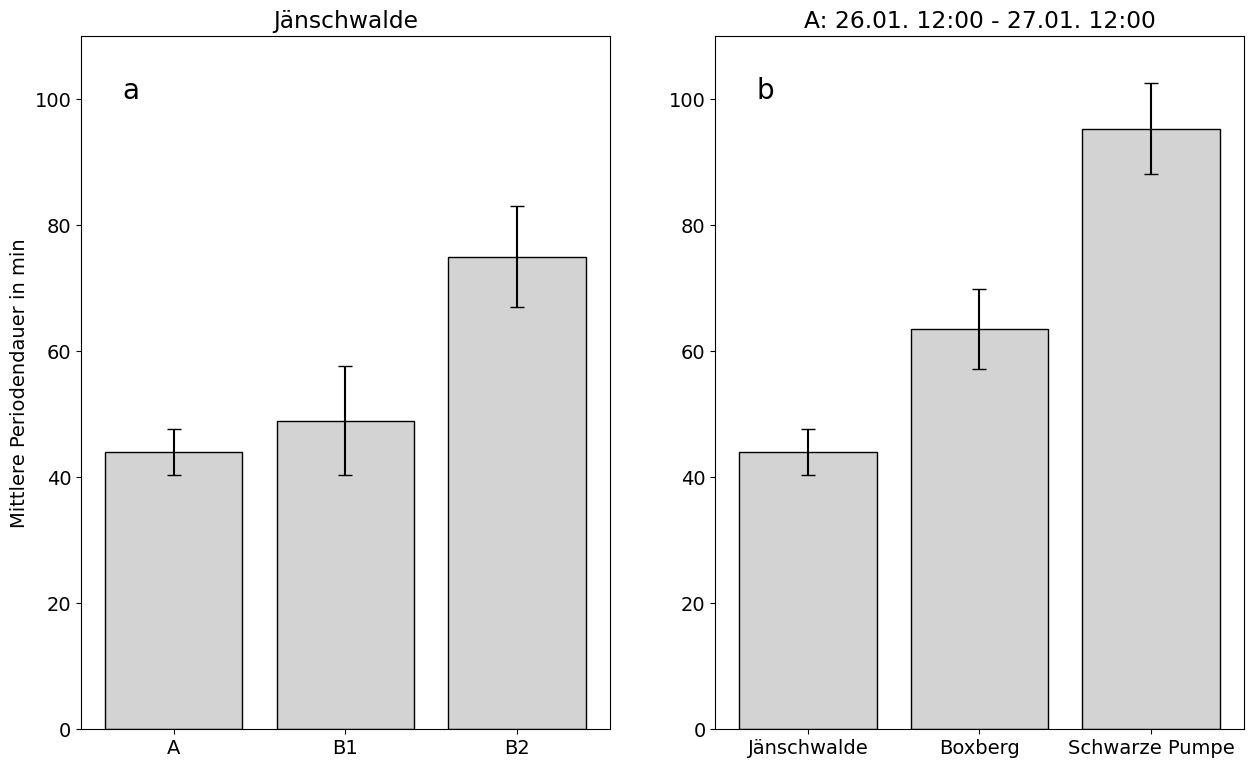

In [27]:
fig = plt.figure()
gs = GridSpec(2, 2, figure=fig)
ax_l = fig.add_subplot(gs[:, 0])
ax_r = fig.add_subplot(gs[:, 1])

ax_l.set_ylim(0, 110)
ax_r.set_ylim(0, 110)

ax_l.set_ylabel("Mittlere Periodendauer in min")

ax_l.bar(
    ["A", "B1", "B2"], 
    [period_a, period_b_1, period_b_2], 
    yerr=[std_a, std_b_1, std_b_2], 
    color='lightgray', edgecolor='black',
    capsize=5
)

ax_r.bar(
    [power_station["name"] for power_station in POWER_STATIONS.values()],
    [day_a_data[power_station][0] for power_station in POWER_STATIONS],
    yerr=[day_a_data[power_station][1] for power_station in POWER_STATIONS],
    color='lightgray', edgecolor='black',
    capsize=5
)

ax_l.text(-0.3, 100, "a", fontsize=20)
ax_r.text(-0.3, 100, "b", fontsize=20)

ax_l.set_title("Jänschwalde")
ax_r.set_title("A: 26.01. 12:00 - 27.01. 12:00")

plt.show()